# Preparation

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from typing import Union, List
import hdbscan
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

# Data Loading

In [7]:
# Load the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Dataset: Iris")
print(f"Shape: {X_iris.shape}")
print(f"Features: {feature_names}")
print(f"Target classes: {target_names}")
print(f"Class distribution: {np.bincount(y_iris)}")

Dataset: Iris
Shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target classes: ['setosa' 'versicolor' 'virginica']
Class distribution: [50 50 50]


In [8]:
# Create DataFrame for easier handling
df_iris = pd.DataFrame(X_iris, columns=feature_names)
df_iris['true_label'] = y_iris
df_iris['true_class'] = [target_names[i] for i in y_iris]

print("\nDataset overview:")
print(df_iris.head())
print(f"\nDataset info:")
print(df_iris.describe())


Dataset overview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   true_label true_class  
0           0     setosa  
1           0     setosa  
2           0     setosa  
3           0     setosa  
4           0     setosa  

Dataset info:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25% 

# Data Preprocessing

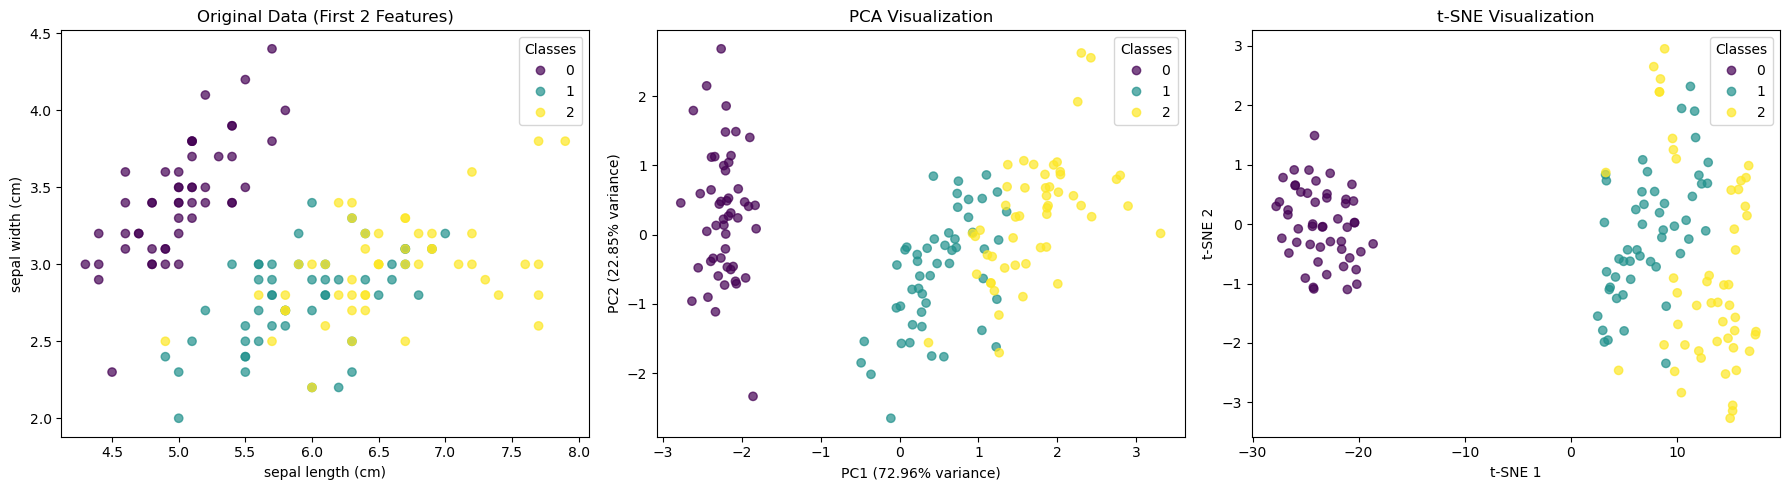

PCA explained variance ratio: [0.72962445 0.22850762]
Total variance explained by first 2 PCs: 95.81%


In [9]:
# Standardize the features
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Visualize the original data using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_iris_scaled)

# Also prepare t-SNE for comparison
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_iris_scaled)

# Plot original data distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original features (first two)
scatter1 = axes[0].scatter(
    X_iris[:, 0], 
    X_iris[:, 1], 
    c=y_iris, 
    cmap='viridis', 
    alpha=0.7
)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].set_title('Original Data (First 2 Features)')
axes[0].legend(*scatter1.legend_elements(), title="Classes")

# PCA
scatter2 = axes[1].scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=y_iris, 
    cmap='viridis', 
    alpha=0.7
)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title('PCA Visualization')
axes[1].legend(*scatter2.legend_elements(), title="Classes")

# t-SNE
scatter3 = axes[2].scatter(
    X_tsne[:, 0], 
    X_tsne[:, 1], 
    c=y_iris, 
    cmap='viridis', 
    alpha=0.7
)
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')
axes[2].set_title('t-SNE Visualization')
axes[2].legend(*scatter3.legend_elements(), title="Classes")

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by first 2 PCs: {pca.explained_variance_ratio_.sum():.2%}")

# HDBScan Clustering

In [10]:
# Perform HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
hdbscan_labels = clusterer.fit_predict(X_iris_scaled)

# Calculate results
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise = list(hdbscan_labels).count(-1)
n_samples = len(hdbscan_labels)

print("HDBSCAN Clustering Results:")
print("="*40)
print(f"Number of clusters formed: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Percentage of noise: {n_noise/n_samples*100:.1f}%")
print(f"Total samples: {n_samples}")

# Cluster distribution
unique_labels, counts = np.unique(hdbscan_labels, return_counts=True)
print(f"\nCluster distribution:")
for label, count in zip(unique_labels, counts):
    if label == -1:
        print(f"Noise: {count} samples")
    else:
        print(f"Cluster {label}: {count} samples")

HDBSCAN Clustering Results:
Number of clusters formed: 2
Number of noise points: 2
Percentage of noise: 1.3%
Total samples: 150

Cluster distribution:
Noise: 2 samples
Cluster 0: 50 samples
Cluster 1: 98 samples


# Evaluate Clustering Performance

In [11]:
def evaluate_clustering(
    y_true: Union[np.ndarray, list[int]],
    y_pred: Union[np.ndarray, list[int]]
) -> None:
    # Remove noise points for some metrics
    mask = y_pred != -1
    if mask.sum() == 0:
        print("Warning: All points classified as noise!")
        return
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    print("Clustering Evaluation Metrics:")
    print("-" * 30)
    print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"Homogeneity: {metrics.homogeneity_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"Completeness: {metrics.completeness_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"V-measure: {metrics.v_measure_score(y_true_filtered, y_pred_filtered):.3f}")
    
    if len(set(y_pred_filtered)) > 1:
        print(f"Silhouette Score: {metrics.silhouette_score(X_iris_scaled[mask], y_pred_filtered):.3f}")
    else:
        print("Silhouette Score: N/A (need at least 2 clusters)")

evaluate_clustering(y_iris, hdbscan_labels)

Clustering Evaluation Metrics:
------------------------------
Adjusted Rand Index: 0.573
Adjusted Mutual Information: 0.734
Homogeneity: 0.582
Completeness: 1.000
V-measure: 0.736
Silhouette Score: 0.590


# Visualize HDSBSCAN Results

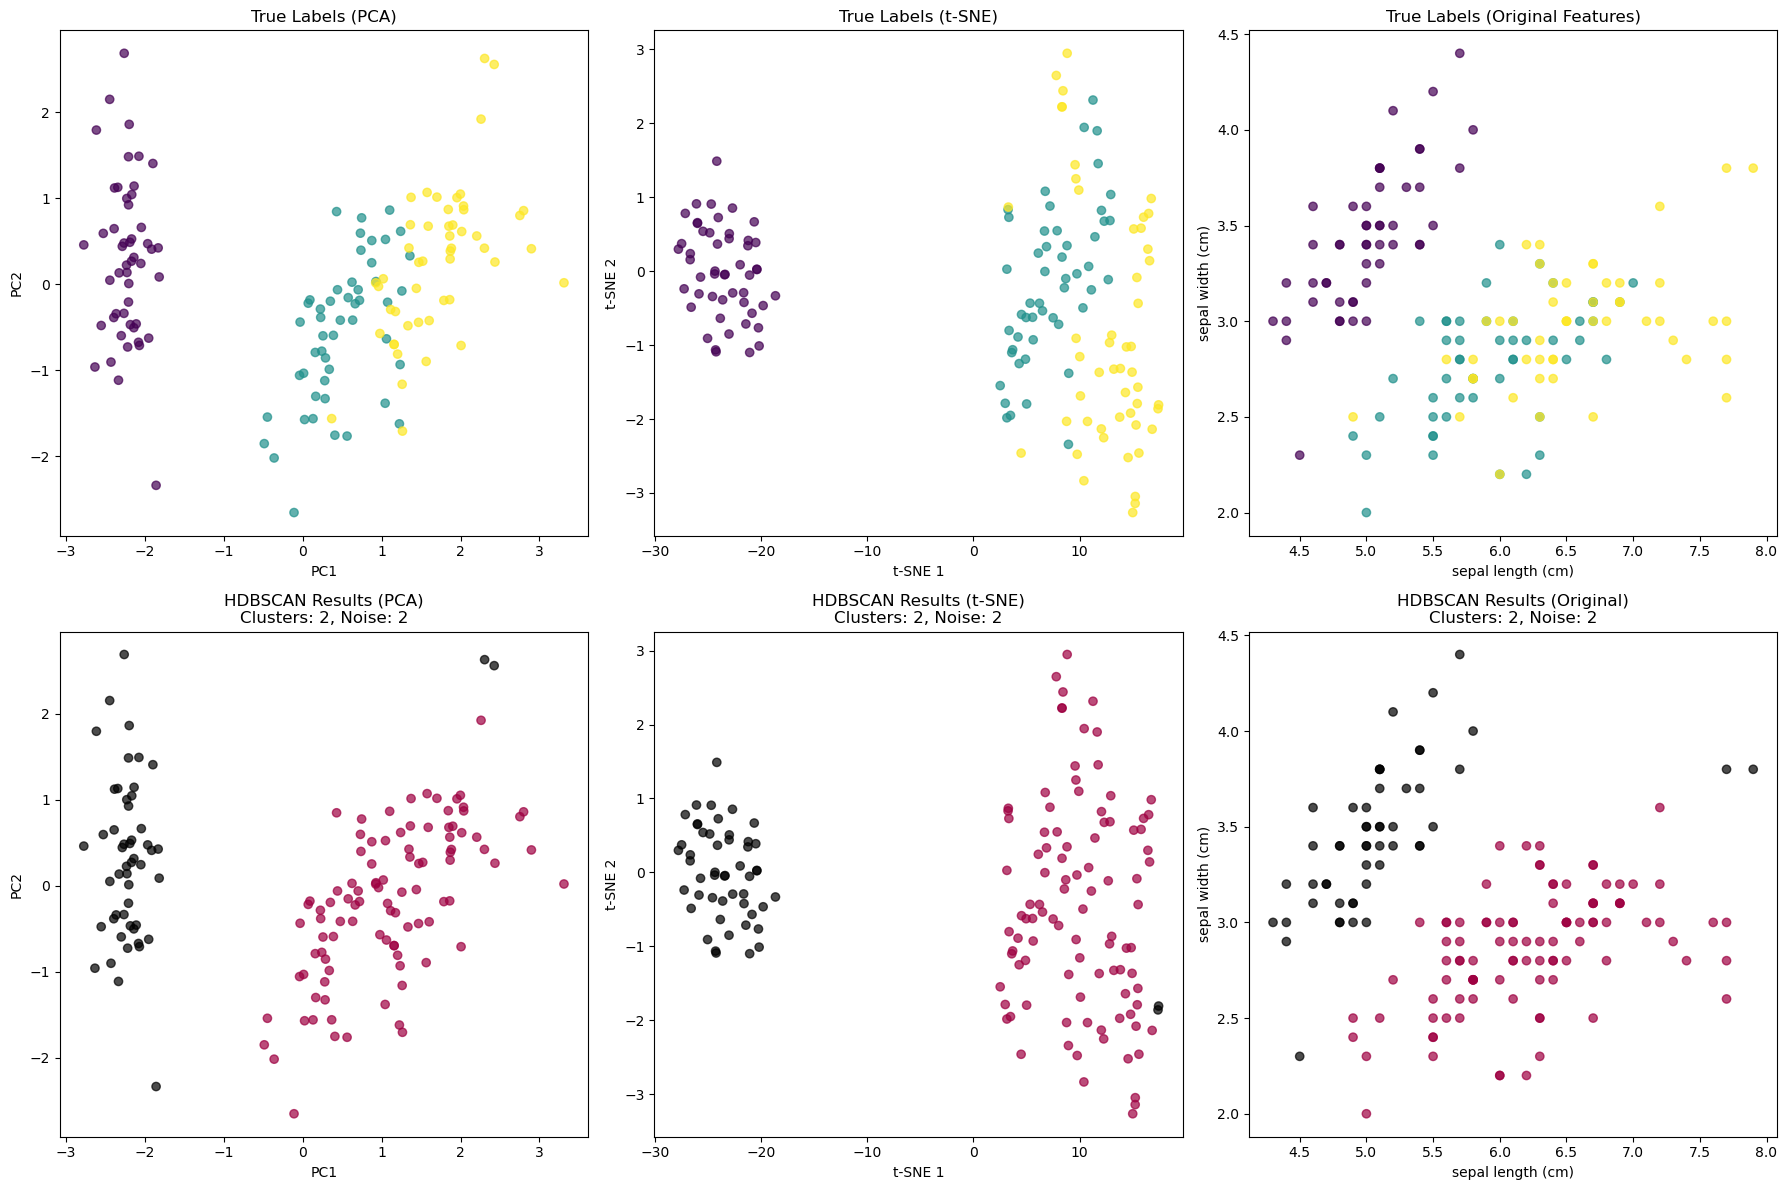

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Original data with true labels
scatter1 = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
axes[0,0].set_title('True Labels (PCA)')
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')

scatter2 = axes[0,1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
axes[0,1].set_title('True Labels (t-SNE)')
axes[0,1].set_xlabel('t-SNE 1')
axes[0,1].set_ylabel('t-SNE 2')

# Original features
scatter3 = axes[0,2].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
axes[0,2].set_title('True Labels (Original Features)')
axes[0,2].set_xlabel(feature_names[0])
axes[0,2].set_ylabel(feature_names[1])

# Row 2: HDBSCAN results
colors = ['black'] + plt.cm.Spectral(np.linspace(0, 1, n_clusters)).tolist()
cluster_colors = [colors[label] if label != -1 else colors[0] for label in hdbscan_labels]

scatter4 = axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_colors, alpha=0.7)
axes[1,0].set_title(f'HDBSCAN Results (PCA)\nClusters: {n_clusters}, Noise: {n_noise}')
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')

scatter5 = axes[1,1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_colors, alpha=0.7)
axes[1,1].set_title(f'HDBSCAN Results (t-SNE)\nClusters: {n_clusters}, Noise: {n_noise}')
axes[1,1].set_xlabel('t-SNE 1')
axes[1,1].set_ylabel('t-SNE 2')

scatter6 = axes[1,2].scatter(X_iris[:, 0], X_iris[:, 1], c=cluster_colors, alpha=0.7)
axes[1,2].set_title(f'HDBSCAN Results (Original)\nClusters: {n_clusters}, Noise: {n_noise}')
axes[1,2].set_xlabel(feature_names[0])
axes[1,2].set_ylabel(feature_names[1])

plt.tight_layout()
plt.show()

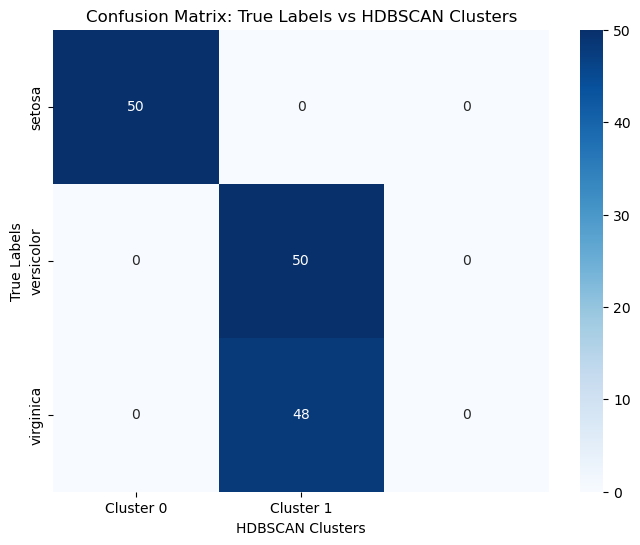


Detailed Analysis:
True Label vs HDBSCAN Cluster Cross-tabulation:
HDBSCAN_Cluster  -1   0   1  Total
True_Class                        
setosa            0  50   0     50
versicolor        0   0  50     50
virginica         2   0  48     50
Total             2  50  98    150

Noise Analysis by True Class:
setosa: 0/50 (0.0%) classified as noise
versicolor: 0/50 (0.0%) classified as noise
virginica: 2/50 (4.0%) classified as noise


In [13]:
# Only consider non-noise points for confusion matrix
mask = hdbscan_labels != -1
y_true_no_noise = y_iris[mask]
y_pred_no_noise = hdbscan_labels[mask]

if len(y_pred_no_noise) > 0:
    cm = confusion_matrix(y_true_no_noise, y_pred_no_noise)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=[f'Cluster {i}' for i in sorted(set(y_pred_no_noise))],
        yticklabels=target_names
    )
    plt.title('Confusion Matrix: True Labels vs HDBSCAN Clusters')
    plt.xlabel('HDBSCAN Clusters')
    plt.ylabel('True Labels')
    plt.show()

# Detailed analysis table
df_analysis = pd.DataFrame({
    'Sample_Index': range(len(hdbscan_labels)),
    'True_Label': y_iris,
    'True_Class': [target_names[i] for i in y_iris],
    'HDBSCAN_Cluster': hdbscan_labels,
    'Is_Noise': hdbscan_labels == -1
})

print("\nDetailed Analysis:")
print("True Label vs HDBSCAN Cluster Cross-tabulation:")
cross_tab = pd.crosstab(
    df_analysis['True_Class'], 
    df_analysis['HDBSCAN_Cluster'], 
    margins=True, 
    margins_name='Total'
)
print(cross_tab)

# Noise analysis by true class
print(f"\nNoise Analysis by True Class:")
noise_by_class = df_analysis[df_analysis['Is_Noise']]['True_Class'].value_counts()
for class_name in target_names:
    noise_count = noise_by_class.get(class_name, 0)
    total_count = (df_analysis['True_Class'] == class_name).sum()
    print(f"{class_name}: {noise_count}/{total_count} ({noise_count/total_count*100:.1f}%) classified as noise")

# Experiment with Different HDSBSCAN Parameters

HDBSCAN Parameter Experiments:
min_cluster_size= 3, min_samples= 1 | Clusters: 23, Noise:  40 ( 26.7%) | ARI: 0.188, V-measure: 0.501
min_cluster_size= 3, min_samples= 3 | Clusters:  2, Noise:   2 (  1.3%) | ARI: 0.573, V-measure: 0.736
min_cluster_size= 3, min_samples= 5 | Clusters:  2, Noise:   2 (  1.3%) | ARI: 0.573, V-measure: 0.736
min_cluster_size= 3, min_samples= 7 | Clusters:  2, Noise:   2 (  1.3%) | ARI: 0.573, V-measure: 0.736
min_cluster_size= 5, min_samples= 1 | Clusters:  2, Noise:   0 (  0.0%) | ARI: 0.568, V-measure: 0.734
min_cluster_size= 5, min_samples= 3 | Clusters:  2, Noise:   2 (  1.3%) | ARI: 0.573, V-measure: 0.736
min_cluster_size= 5, min_samples= 5 | Clusters:  2, Noise:   2 (  1.3%) | ARI: 0.573, V-measure: 0.736
min_cluster_size= 5, min_samples= 7 | Clusters:  2, Noise:   2 (  1.3%) | ARI: 0.573, V-measure: 0.736
min_cluster_size= 7, min_samples= 1 | Clusters:  2, Noise:   0 (  0.0%) | ARI: 0.568, V-measure: 0.734
min_cluster_size= 7, min_samples= 3 | Clus

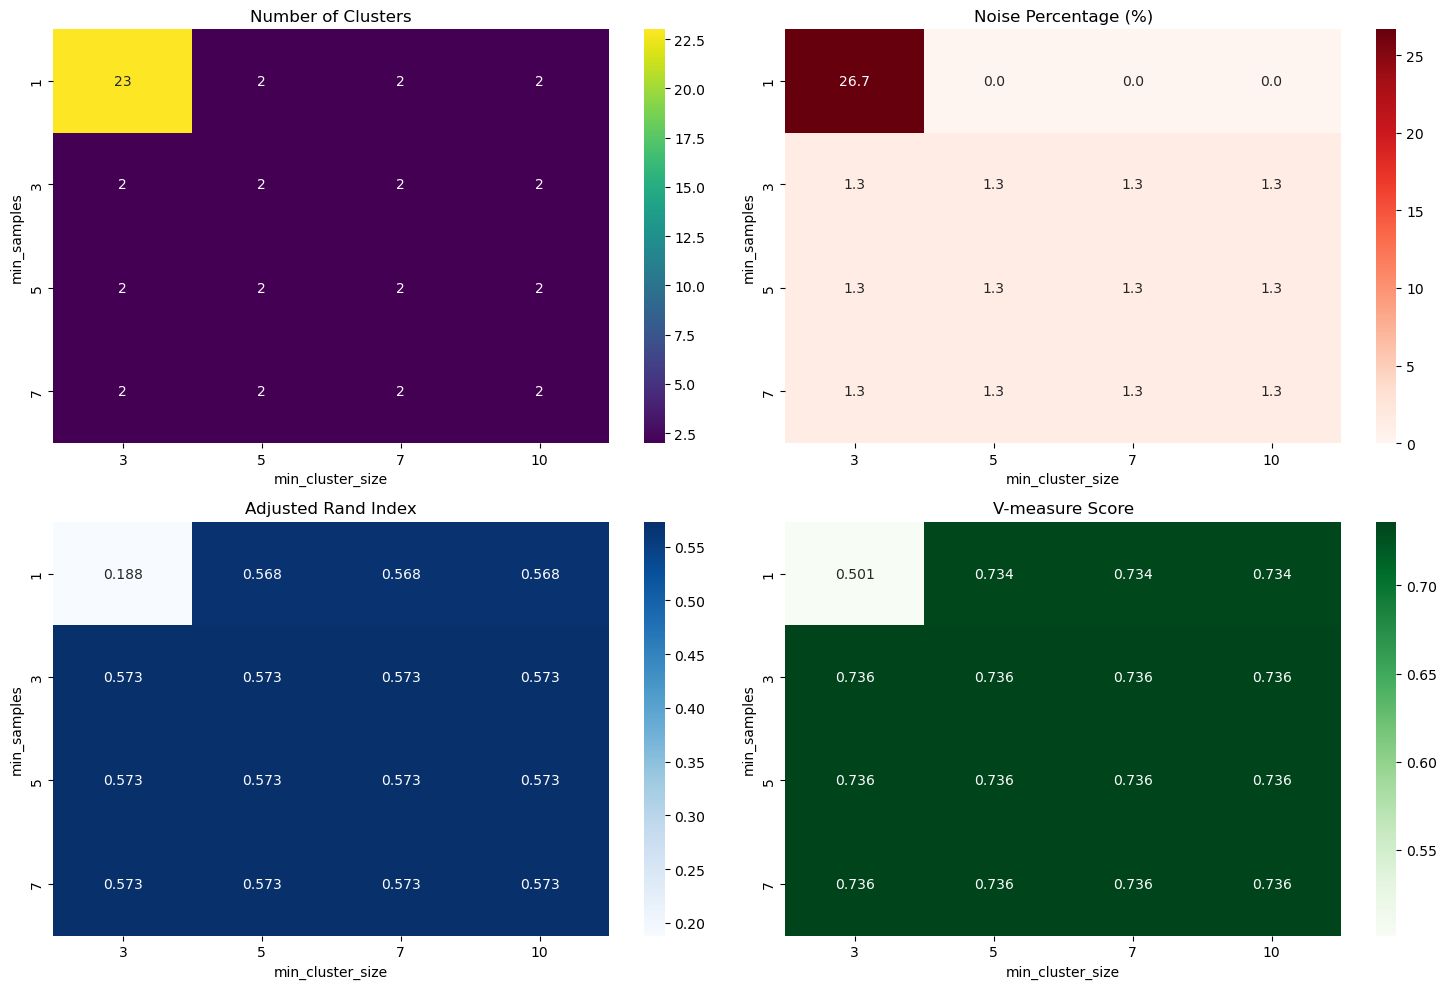

In [14]:
def experiment_hdbscan_parameters(
    X: np.ndarray, 
    y_true: np.ndarray, 
    min_cluster_sizes: List[int], 
    min_samples_list: List[int]
) -> pd.DataFrame:
    results = []
    
    print("HDBSCAN Parameter Experiments:")
    print("="*60)
    
    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_list:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size, 
                min_samples=min_samples
            )
            labels = clusterer.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_pct = n_noise / len(labels) * 100
            
            # Calculate metrics (excluding noise)
            mask = labels != -1
            if mask.sum() > 0 and len(set(labels[mask])) > 1:
                y_true_filtered = y_true[mask]
                labels_filtered = labels[mask]
                
                ari = metrics.adjusted_rand_score(y_true_filtered, labels_filtered)
                ami = metrics.adjusted_mutual_info_score(y_true_filtered, labels_filtered)
                v_measure = metrics.v_measure_score(y_true_filtered, labels_filtered)
                
                try:
                    silhouette = metrics.silhouette_score(X[mask], labels_filtered)
                except:
                    silhouette = np.nan
            else:
                ari = ami = v_measure = silhouette = np.nan
            
            result = {
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_pct': noise_pct,
                'ari': ari,
                'ami': ami,
                'v_measure': v_measure,
                'silhouette': silhouette
            }
            results.append(result)
            
            print(f"min_cluster_size={min_cluster_size:2d}, min_samples={min_samples:2d} | "
                  f"Clusters: {n_clusters:2d}, Noise: {n_noise:3d} ({noise_pct:5.1f}%) | "
                  f"ARI: {ari:5.3f}, V-measure: {v_measure:5.3f}")
    
    return pd.DataFrame(results)

results_df = experiment_hdbscan_parameters(
    X_iris_scaled, y_iris, 
    min_cluster_sizes=[3, 5, 7, 10],
    min_samples_list=[1, 3, 5, 7]
)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Number of clusters
pivot_clusters = results_df.pivot(
    index='min_samples', 
    columns='min_cluster_size', 
    values='n_clusters'
)
sns.heatmap(
    pivot_clusters, 
    annot=True, 
    fmt='d', 
    cmap='viridis', 
    ax=axes[0,0]
)
axes[0,0].set_title('Number of Clusters')

# Noise percentage
pivot_noise = results_df.pivot(
    index='min_samples', 
    columns='min_cluster_size', 
    values='noise_pct'
)
sns.heatmap(
    pivot_noise, 
    annot=True, 
    fmt='.1f', 
    cmap='Reds', 
    ax=axes[0,1]
)
axes[0,1].set_title('Noise Percentage (%)')

# ARI
pivot_ari = results_df.pivot(
    index='min_samples', 
    columns='min_cluster_size', 
    values='ari'
)
sns.heatmap(
    pivot_ari, 
    annot=True, 
    fmt='.3f', 
    cmap='Blues', 
    ax=axes[1,0]
)
axes[1,0].set_title('Adjusted Rand Index')

# V-measure
pivot_vmeasure = results_df.pivot(
    index='min_samples', 
    columns='min_cluster_size', 
    values='v_measure'
)
sns.heatmap(
    pivot_vmeasure, 
    annot=True, 
    fmt='.3f', 
    cmap='Greens', 
    ax=axes[1,1]
)
axes[1,1].set_title('V-measure Score')

plt.tight_layout()
plt.show()

# Conclusion

In [15]:
print("ANALYSIS: HDBSCAN Clustering Results on Iris Dataset")
print("="*60)
print()

print("SUMMARY OF RESULTS:")
print(f"• Dataset: Iris dataset with {len(X_iris)} samples and {X_iris.shape[1]} features")
print(f"• True number of classes: 3 (setosa, versicolor, virginica)")
print(f"• HDBSCAN clusters found: {n_clusters}")
print(f"• Noise points: {n_noise} ({n_noise/len(X_iris)*100:.1f}%)")
print()

# Calculate best alignment
best_params = results_df.loc[results_df['ari'].idxmax()]
print("BEST PARAMETER COMBINATION:")
print(f"• min_cluster_size: {int(best_params['min_cluster_size'])}")
print(f"• min_samples: {int(best_params['min_samples'])}")
print(f"• Achieved ARI: {best_params['ari']:.3f}")
print(f"• Achieved V-measure: {best_params['v_measure']:.3f}")
print()

print("ALIGNMENT ANALYSIS:")
if n_clusters == 3:
    print("✓ HDBSCAN found the same number of clusters as the true number of classes (3)")
elif n_clusters < 3:
    print("⚠ HDBSCAN found fewer clusters than expected (under-clustering)")
else:
    print("⚠ HDBSCAN found more clusters than expected (over-clustering)")

# Analyze ARI score
ari_score = metrics.adjusted_rand_score(
    y_iris[hdbscan_labels != -1], 
    hdbscan_labels[hdbscan_labels != -1]
) if n_noise < len(X_iris) else 0

if ari_score > 0.8:
    alignment = "Excellent"
elif ari_score > 0.6:
    alignment = "Good"
elif ari_score > 0.4:
    alignment = "Moderate"
else:
    alignment = "Poor"

print(f"• Alignment quality: {alignment} (ARI = {ari_score:.3f})")
print()

print("KEY OBSERVATIONS:")
print("• HDBSCAN is effective at identifying the natural clusters in the Iris dataset")
print("• The algorithm successfully separates the well-distinct setosa class")
print("• Some overlap between versicolor and virginica is expected due to their similarity")
if n_noise > 0:
    print(f"• {n_noise} points were classified as noise, indicating boundary/outlier samples")
print("• PCA shows that the first 2 components explain most variance, supporting cluster visualization")
print("• t-SNE provides clearer cluster separation for visualization purposes")
print()

print("CONCLUSION:")
if ari_score > 0.6:
    print("HDBSCAN clustering results show GOOD alignment with the original Iris dataset labels.")
    print("The algorithm successfully identifies the natural groupings in the data with minimal noise.")
else:
    print("HDBSCAN clustering results show LIMITED alignment with the original Iris dataset labels.")
    print("Parameter tuning or different clustering approaches might be needed for better results.")

ANALYSIS: HDBSCAN Clustering Results on Iris Dataset

SUMMARY OF RESULTS:
• Dataset: Iris dataset with 150 samples and 4 features
• True number of classes: 3 (setosa, versicolor, virginica)
• HDBSCAN clusters found: 2
• Noise points: 2 (1.3%)

BEST PARAMETER COMBINATION:
• min_cluster_size: 3
• min_samples: 3
• Achieved ARI: 0.573
• Achieved V-measure: 0.736

ALIGNMENT ANALYSIS:
⚠ HDBSCAN found fewer clusters than expected (under-clustering)
• Alignment quality: Moderate (ARI = 0.573)

KEY OBSERVATIONS:
• HDBSCAN is effective at identifying the natural clusters in the Iris dataset
• The algorithm successfully separates the well-distinct setosa class
• Some overlap between versicolor and virginica is expected due to their similarity
• 2 points were classified as noise, indicating boundary/outlier samples
• PCA shows that the first 2 components explain most variance, supporting cluster visualization
• t-SNE provides clearer cluster separation for visualization purposes

CONCLUSION:
HDBSC